In [1]:
import os
import mmcv
from mmcv import Config

from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import single_gpu_test

from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel

import pandas as pd
import numpy as np
import json
import torch

# ensemble test
## setting

In [2]:
cfg = Config.fromfile('/opt/ml/mmsegmentation/configs/1.myconfig/upernet_swin.py')
root = '/opt/ml/mmsegmentation/data/images/test'

cfg.data.test.img_dir = root
cfg.data.test.pipeline[1]['img_scale'] = (512,512)
cfg.data.test.test_mode = True


# cfg.work_dir = '/opt/ml/lab/mmsegmentation/work_dirs'
cfg.work_dir = '/opt/ml/mmsegmentation/work_dirs/upernet_swin'

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None
cfg.model['type'] = 'EncoderDecoderInference'

#define dataset
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

2021-11-04 08:32:16,125 - mmseg - INFO - Loaded 819 images


In [3]:
# cfg.model

In [3]:
def get_pred_logit(model_path, CLASSES):
    model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
    checkpoint = load_checkpoint(model, model_path, map_location='cpu')
    cfg.model['pretrained'] = None
    model.CLASSES = CLASSES
    model = MMDataParallel(model.cuda(), device_ids=[0])

    return single_gpu_test(model, data_loader)

In [4]:
# output_1 = get_pred_logit('/opt/ml/mmsegmentation/work_dirs/upernet_swin/swin_pseudo_Fold_1.pth', dataset.CLASSES)
# output_2 = get_pred_logit('/opt/ml/mmsegmentation/work_dirs/upernet_swin/swin_pseudo_Fold_2.pth', dataset.CLASSES)
# output_3 = get_pred_logit('/opt/ml/mmsegmentation/work_dirs/upernet_swin/swin_pseudo_Fold_3.pth', dataset.CLASSES)
output_4 = get_pred_logit('/opt/ml/mmsegmentation/work_dirs/upernet_swin/swin_pseudo2_Fold_4.pth', dataset.CLASSES)
# output_5 = get_pred_logit('/opt/ml/mmsegmentation/work_dirs/upernet_swin/swin_pseudo_Fold_5.pth', dataset.CLASSES)

/opt/ml/mmsegmentation/mmseg/models/backbones/swin.py:553: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


Use load_from_local loader
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.3 task/s, elapsed: 155s, ETA:     0s

### ensemble start
- result = sum(output_1, output_2)
- argmax(result, axis=0)

In [ ]:
# def cal_class_counts(value):
#     classes, counts = np.unique(value, return_counts=True)
#     for i,v in zip(classes, counts):
#         print(i,v)
        
# for item in predict_mask_array:
#     cal_class_counts(item)

0 149133
1 759
8 112252
0 149489
8 112655
0 148283
1 25927
8 87934
0 148854
1 59
8 113231
0 150062
1 9568
6 69
8 102445


In [43]:
output_to_mask = []
crf_output_to_mask = []
a = 0

# for item_1 in output_1:
#     for idx in range(11):
#         a += item_1[idx][0][5]
#         print(item_1[idx][0][5])
    
#     break
    
# print(a)
    # new_item = item_1 + item_2 + item_3 + item_4 + item_5
    # output_to_mask.append(new_item.argmax(axis=0))

In [ ]:
# weight_model1 = [1, 1.05, 1, 1.18, 1.14, 0.95, 1.03, 0.99, 1, 1.07, 1.02]
# weight_model2 = [1, 0.84, 0.98, 0.94, 1.05, 0.86, 1.07, 0.93, 0.99, 0.76, 1.06]
# weight_model3 = [1, 1.05, 1, 0.93, 0.99, 1.18, 0.92, 1.09, 1.01, 1.07, 1.23]
# weight_model4 = [1, 0.93, 1.02, 1.05, 0.93, 1, 1.03, 0.99, 1.01, 1.06, 0.83]
# weight_model5 = [1, 1.12, 1, 0.91, 0.89, 1.02, 0.94, 1.01, 1, 1.04, 0.86]
weight_model1 = [1,1,1,1,1,1,1,1,1,1,1]
weight_model2 = [1,1,1,1,1,1,1,1,1,1,1]
weight_model3 = [1,1,1,1,1,1,1,1,1,1,1]
weight_model4 = [1,1,1,1,1,1,1,1,1,1,1]
weight_model5 = [1,1,1,1,1,1,1,1,1,1,1]

def weight_apply(item_1, item_2, item_3, item_4, item_5):
    # print(item_1.shape)
    for idx in range(11):
        item_1[idx] *= weight_model1[idx]
    for idx in range(11):
        item_2[idx] *= weight_model2[idx]
    for idx in range(11):
        item_3[idx] *= weight_model3[idx]
    for idx in range(11):
        item_4[idx] *= weight_model4[idx]
    for idx in range(11):
        item_5[idx] *= weight_model5[idx]
    
    return item_1, item_2, item_3, item_4, item_5

In [18]:
output_4[0][:,:1,:1]

819

In [57]:
output_to_mask = []

for item in output_4:
    new_item = item
    output_to_mask.append(new_item.argmax(axis=0))

# for item_1, item_2, item_3, item_4, item_5 in zip(output_1, output_2, output_3, output_4, output_5):
#     # item_1, item_2, item_3, item_4, item_5 = weight_apply(item_1, item_2, item_3, item_4, item_5)
#     new_item = item_1 + item_2 + item_3 + item_4 + item_5
#     output_to_mask.append(new_item.argmax(axis=0))

In [13]:
import numpy as np
import pydensecrf.densecrf as dcrf
# from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
%matplotlib inline

# from skimage.io import imread, imsave
# from skimage.color import gray2rgb
# from skimage.color import rgb2gray

In [5]:
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)


def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [31]:
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    
    # print(labels.shape[0])
    # U = unary_from_softmax(sm, scale=None, clip=1e-5)
    # unary_from_softmax(sm, scale=None, clip=1e-5):
    
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(10,10), srgb=(70,70,70), rgbim=original_image, compat=5)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [54]:
print(output_4[0].shape)
print(output_to_mask[0].shape)

(11, 512, 512)
(512, 512)


In [ ]:
crf_output_to_mask = []

for idx, mask in tqdm(enumerate(output_to_mask)):
    image = cv2.imread(dataset[idx]['img_metas'][0].data['filename'])
    crf_output = crf(image, mask)
    crf_output_to_mask.append(crf_output)

749it [50:52,  4.15s/it]

In [ ]:
output_to_mask[0].shape

(512, 512)

In [ ]:
import os


from_filelist = [
    "D:/tmp/1/1.txt",
    "D:/tmp/1/2.txt",
]

    

In [ ]:
import os
import cv2
import shutil

for index, predict in enumerate(output_to_mask):
    original_image = dataset[index]['img_metas'][0].data['filename']
    shutil.copyfile(original_image, os.path.join('/opt/ml/mmsegmentation/data/images/esb_test', f"{index+5000:04}.jpg"))
    
    file_dir = os.path.join("/opt/ml/mmsegmentation/data/annotations/esb_test", f"{index+5000:04}.png")
    cv2.imwrite(file_dir, predict)


In [ ]:
# def cal_class_counts(value):
#     classes, counts = np.unique(value, return_counts=True)
#     for i,v in zip(classes, counts):
#         print(i,v)

# for item in output_to_mask:
#     cal_class_counts(item)

In [ ]:
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict3.csv")

In [ ]:
def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
json_dir = os.path.join("/opt/ml/segmentation/input/data/test.json") # original json file
with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size

# PredictionString 대입
for image_id, predict in enumerate(crf_output_to_mask):
    image_id = datas["images"][image_id]
    file_name = image_id["file_name"]
    
    temp_mask = []
    predict = predict.reshape(1, 512, 512)
    mask = predict.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2) # resize to 256*256
    temp_mask.append(mask)
    oms = np.array(temp_mask)
    oms = oms.reshape([oms.shape[0], output_size*output_size]).astype(int)

    string = oms.flatten()

    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(os.path.join(cfg.work_dir, f'submission_ensemble_pseudo_v2_crf_fold_4.csv'), index=False)

In [ ]:
image_index * 4

704

In [76]:
image_index = 0
colnum = 8
rownum = 4

IndexError: list index out of range

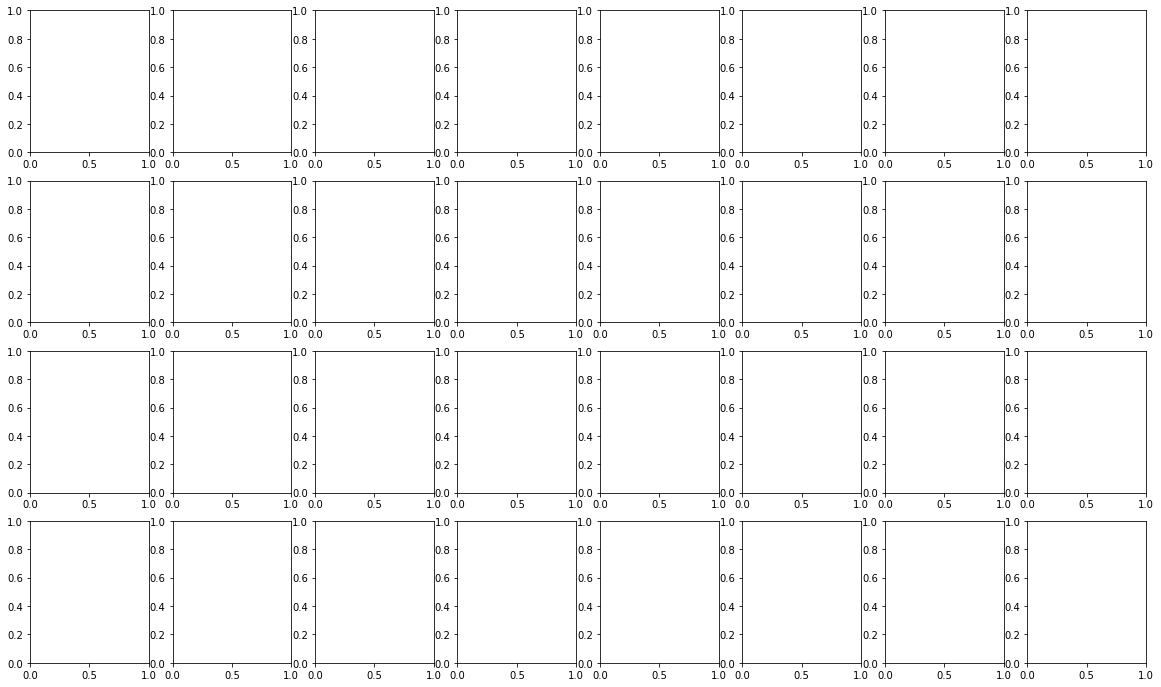

In [128]:
from matplotlib.patches import Patch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import webcolors
import cv2

category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                        edgecolor=webcolors.rgb_to_hex(rgb), 
                        label=category) for category, rgb in category_and_rgb]

fig, ax = plt.subplots(nrows=rownum, ncols=colnum, figsize=(20, 12))

predict_mask_array = []

for sequence in range(rownum):
    Cur_Index = image_index * rownum + sequence
    original_image = dataset[Cur_Index]['img_metas'][0].data['filename']
    original_image = img.imread(original_image)
    ground_truth = Image.open(os.path.join('/opt/ml/mmsegmentation/data/annotations/esb_test', f"{Cur_Index+4000:04}.png"))
    ground_truth = np.array(ground_truth)
    predict_mask_array.append(original_image)
    predict_mask_array.append(label_to_color_image(ground_truth))
    predict_mask_array.append(label_to_color_image(output_to_mask[Cur_Index]))
    predict_mask_array.append(label_to_color_image(output_1[Cur_Index].argmax(axis=0)))
    predict_mask_array.append(label_to_color_image(output_2[Cur_Index].argmax(axis=0)))
    predict_mask_array.append(label_to_color_image(output_3[Cur_Index].argmax(axis=0)))
    predict_mask_array.append(label_to_color_image(output_4[Cur_Index].argmax(axis=0)))
    predict_mask_array.append(label_to_color_image(output_5[Cur_Index].argmax(axis=0)))
    image_index += 1

for row in range(rownum):
    for col in range(colnum):
        if col % colnum == 0:
            ax[row][col].set_title(f'Original Image')
            ax[row][col].imshow(predict_mask_array[row * colnum + col])
        elif col % colnum == 1:
            ax[row][col].set_title(f'Pseudo Image')
            ax[row][col].imshow(predict_mask_array[row * colnum + col])
        elif col % colnum == 2:
            ax[row][col].set_title(f'ensemble output')
            ax[row][col].imshow(predict_mask_array[row * colnum + col])
        else:    
            ax[row][col].set_title(f'output{col-2} mask')
            ax[row][col].imshow(predict_mask_array[row * colnum + col])
            if col == colnum-1:
                ax[row][col].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()